In [1]:
import numpy as np
import arviz as az
# import pymc3 as pm
import pickle
import matplotlib.pyplot as plt
from google.protobuf import text_format
from scipy.stats import multivariate_normal as mvn
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.interpolate import griddata
from pp_mix.interface import estimate_density_seq
from pp_mix.params_helper import make_default_strauss
import pp_mix.protos.py.params_pb2 as params_pb2


from pp_mix.state import extract_chain
from pp_mix.interface import ConditionalMCMC, estimate_density_seq, simulate_strauss2d
from pp_mix.utils import loadChains, to_numpy, to_proto
from pp_mix.protos.py.state_pb2 import MultivariateMixtureState
from pp_mix.protos.py.params_pb2 import Params

In [2]:
params_file = "pp_mix/resources/sampler_params.asciipb"
params = Params()
with open(params_file, 'r') as fp:
    params = Params()
    text_format.Parse(fp.read(), params)
    
    
params.wishart.sigma = 0.01
params.strauss.init.gamma = 1e-30
params.strauss.init.beta = 0.001
params.strauss.init.R = 5.0
params.strauss.fixed_params = True

## SIMULATION 0

In [ ]:
# sigma1 = np.array([[1, 0], [0, 3]])
# sigma2 = np.array([[3, 0], [0, 1]])

# data = np.vstack([
#        [mvn.rvs(mean=np.array([5, 5]), cov=np.eye(2)) for _ in range(100)],
#        [mvn.rvs(mean=np.array([-5, -5]), cov=np.eye(2)) for _ in range(100)],
#        [mvn.rvs(mean=np.array([5, -5]), cov=sigma1) for _ in range(100)],
#        [mvn.rvs(mean=np.array([-5, 5]), cov=sigma2) for _ in range(100)]])

# plt.scatter(data[:, 0], data[:, 1])

In [ ]:
# np.savetxt("data/data_0.txt", data)

In [ ]:
data = np.loadtxt("data/data_0.txt")

In [ ]:
# sampler0 = ConditionalMCMC(params=params, fixed_pp=True, inits=[0.00001, 1e-30, 5.0])
sampler0 = ConditionalMCMC(
    pp_params=params.strauss,
    prec_params=params.wishart,
    jump_params=params.gamma_jump)

sampler0.run(50000, 50000, 10, data)
# sampler0.serialize_chains("data/chains_sim_0.recordio")

In [ ]:
k_chain_raf = np.loadtxt("data/data_0_K_raf.txt")
k_chain_bnp = np.loadtxt("data/data_0_K_bnpmix.txt")

In [ ]:
chains = sampler0.chains
ma_chain = np.array([len(x.a_means) for x in chains])
mna_chain = np.array([(x.mna) for x in chains])

width = 0.2
bars = np.arange(max(np.max(ma_chain), 6))
heights = np.array([np.sum(ma_chain ==i ) for i in bars])
plt.bar(bars - width, heights / len(ma_chain), width=width,
        edgecolor="white", label="strauss")

bars = np.arange(max(np.max(k_chain_raf), 5.0))
heights = np.array([np.sum(k_chain_raf ==i ) for i in bars])
plt.bar(bars, heights / len(k_chain_raf), width=width,
        edgecolor="white", label="finite mixture")

bars = np.arange(max(np.max(k_chain_bnp), 6))
heights = np.array([np.sum(k_chain_bnp == i ) for i in bars])
plt.bar(bars + width, heights / len(k_chain_bnp), width=width,
        edgecolor="white", label="DPM")

plt.legend()
# plt.savefig("images/data_0_histogram_K.pdf")
plt.show()

In [ ]:
np.sum(ma_chain == 4) / 5000

In [ ]:
wh = np.where(ma_chain == 5)[0]
N = len(wh)
np.sum((wh < 3000) & (wh > 2000))  / N

In [ ]:
ma_chain = np.array([np.max(x.clus_alloc) + 1 for x in chains])
np.where(ma_chain == 5)

### DENSITY ESTIMATION

In [ ]:
x_ = np.linspace(-10, 10, 100)
y_ = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x_, y_)
grid = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

estimate = estimate_density_seq(chains, grid)
our_estimate = np.mean(estimate, axis=0)

In [ ]:
bnpmix_estimate = np.loadtxt("data/data_1_dens_bnpmix.txt")

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

bnpmix_Z = griddata(grid, bnpmix_estimate, (x, y))
cntr1 = plt.contour(x, y, bnpmix_Z, colors="darkgreen", linewidths=3.5, 
            linestyles="dashed")

our_Z = griddata(grid, our_estimate, (x, y))
cntr2 = plt.contour(x, y, our_Z, colors="steelblue", linewidths=3.5, 
            linestyles="dashed")

plt.scatter(data[:, 0], data[:, 1], s=3, color="black")

h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()

ax.legend([h1[0], h2[0]], ['DPM', 'strauss'], loc="upper left")
# plt.savefig("images/data_0_dens_estimate.pdf")

plt.show()

## SIMULATION 1

In [ ]:
# data = np.vstack([
#        [mvn.rvs(mean=np.array([5, 5]), cov=np.eye(2)) for _ in range(100)],
#        [mvn.rvs(mean=np.array([-5, -5]), cov=np.eye(2)) for _ in range(100)]])

# xx = np.hstack([
#         np.array([skewnorm.rvs(2, -3, 1.5) for i in range(200)]).reshape(-1, 1),
#         np.array([skewnorm.rvs(2, -3, 1.5) for i in range(200)]).reshape(-1, 1)])

# yy = np.array(
#     [mvn.rvs(mean=np.array([3, 3]), cov=np.eye(2)) for _ in range(200)])  
# data = np.vstack([xx, yy])

data = np.loadtxt("data/data_1.txt")

In [ ]:
sampler = ConditionalMCMC(
    pp_params=params.strauss,
    prec_params=params.wishart,
    jump_params=params.gamma_jump)
sampler.run(50000, 50000, 10, data)

In [ ]:
# sampler.serialize_chains("data/chains_sim_1.recordio")

In [ ]:
k_chain_raf = np.loadtxt("data/data_1_K_raf.txt")
k_chain_bnp = np.loadtxt("data/data_1_K_bnpmix.txt")

In [ ]:
chains = sampler.chains
ma_chain = np.array([max(x.clus_alloc) + 1 for x in chains])
mna_chain = np.array([(x.mna) for x in chains])
np.savetxt("data/data_1_K_our.txt", ma_chain)

width = 0.2
bars = np.arange(max(np.max(ma_chain), 4))
heights = np.array([np.sum(ma_chain ==i ) for i in bars])
plt.bar(bars - width, heights / len(ma_chain), width=width,
        edgecolor="white", label="strauss")

bars = np.arange(max(np.max(k_chain_raf), 4))
heights = np.array([np.sum(k_chain_raf ==i ) for i in bars])
plt.bar(bars, heights / len(k_chain_raf), width=width,
        edgecolor="white", label="finite mixture")

bars = np.arange(max(np.max(k_chain_bnp), 4))
heights = np.array([np.sum(k_chain_bnp ==i ) for i in bars])
plt.bar(bars + width, heights / len(k_chain_bnp), width=width,
        edgecolor="white", label="DPM")


# bars = np.arange(max(np.max(mna_chain), 4))
# heights = np.array([np.sum(mna_chain ==i ) for i in bars])
# plt.bar(bars + 0.05, heights / len(mna_chain), width=0.2)

plt.legend()
# plt.savefig("images/data_1_histogram_K.pdf")
plt.show()

### DENSITY ESTIMATE

In [ ]:
x_ = np.linspace(-6, 7, 100)
y_ = np.linspace(-6, 7, 100)
x, y = np.meshgrid(x_, y_)
grid = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

estimate = estimate_density_seq(chains, grid)
our_estimate = np.mean(estimate, axis=0)

In [ ]:
bnpmix_estimate = np.loadtxt("data/data_1_dens_bnpmix.txt")

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

bnpmix_Z = griddata(grid, bnpmix_estimate, (x, y))
cntr1 = plt.contour(x, y, bnpmix_Z, colors="darkgreen", linewidths=3.5, 
            linestyles="dashed")

our_Z = griddata(grid, our_estimate, (x, y))
cntr2 = plt.contour(x, y, our_Z, colors="steelblue", linewidths=3.5, 
            linestyles="dashed")

plt.scatter(data[:, 0], data[:, 1], s=3, color="black")

h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()

ax.legend([h1[0], h2[0]], ['DPM', 'strauss'], loc="upper left")
# plt.savefig("images/data_1_dens_estimate.pdf")

plt.show()

## Univariate Like Miller and Dunson

In [ ]:
from scipy.stats import dirichlet

true_mu = np.array([-3.5, 3, 0, 6])
true_sigma = np.array([0.8, 0.5, 0.4, 0.5])
w_t = np.array([0.25, 0.25, 0.3, 0.2])

alpha0 = 500
L = 10000
y_t = np.random.choice(len(w_t), size=L, replace=True, p=w_t)
locations = true_mu[y_t] + true_sigma[y_t] * np.random.normal(size=L)
weights = dirichlet.rvs(np.ones(L) * 500 / L)[0, :]
s = 0.25


def f0(x):
    out = np.zeros_like(x)
    for w, l in zip(weights, locations):
        out += w * norm.pdf(x, l, s)
    return out

def generate_data(size):
    clus_alloc = np.random.choice(L, size=size, replace=True, p=weights)
    out = np.random.normal(size=size) * s + locations[clus_alloc]
    return out

In [ ]:
xgrid = np.linspace(-6, 8, 500)
plt.plot(xgrid, f0(xgrid))

In [ ]:
data = generate_data(500)
# np.savetxt("data/data_univ_0.txt", data)
# data = np.loadtxt("data/data_univ_0.txt")
plt.hist(data)

In [ ]:
strauss_params = make_default_strauss(data.reshape(-1, 1))
strauss_params

In [ ]:
strauss_params = make_default_strauss(data.reshape(-1, 1))
# nrep_params = params_pb2.NrepParams(u=0.5, p=0.9)
gamma_prec_params = params_pb2.GammaParams(alpha=1, beta=5)
gamma_jump_params = params_pb2.GammaParams(alpha=1, beta=1)

strauss_params.init.gamma = 1e-50
strauss_params.init.beta = 0.0000001
strauss_params.fixed_params = True

sampler = ConditionalMCMC(pp_params=strauss_params, 
                          prec_params=gamma_prec_params,
                          jump_params=gamma_prec_params)


sampler.run(50000, 50000, 10, data)

In [ ]:
from scipy.stats import norm
import seaborn as sns

xgrid = np.linspace(-6, 8, 500)
dens = estimate_density_seq(sampler.chains, xgrid)

# bnpmix_estimate = np.loadtxt("data/data_0_univ_dens_bnpmix.txt")

plt.plot(xgrid, np.mean(dens, axis=0))
# plt.plot(xgrid, f0(xgrid))
# plt.plot(grid, np.mean(bnpmix_estimate, axis=0))

In [ ]:
k_chain_raf = np.loadtxt("data/data_univ_0_K_raf.txt")
k_chain_bnp = np.loadtxt("data/data_0_univ_K_bnpmix.txt")


chains = sampler.chains
ma_chain = np.array([max(x.clus_alloc) + 1 for x in chains])
mna_chain = np.array([(x.mna) for x in chains])
np.savetxt("data/data_1_K_our.txt", ma_chain)

width = 0.2
bars = np.arange(max(np.max(ma_chain), 4))
heights = np.array([np.sum(ma_chain ==i ) for i in bars])
plt.bar(bars - width, heights / len(ma_chain), width=width,
        edgecolor="white", label="strauss")

# bars = np.arange(max(np.max(k_chain_raf), 4))
# heights = np.array([np.sum(k_chain_raf ==i ) for i in bars])
# plt.bar(bars, heights / len(k_chain_raf), width=width,
#         edgecolor="white", label="finite mixture")

# bars = np.arange(max(np.max(k_chain_bnp), 4))
# heights = np.array([np.sum(k_chain_bnp ==i ) for i in bars])
# plt.bar(bars + width, heights / len(k_chain_bnp), width=width,
#         edgecolor="white", label="DPM")

# plt.xlim((1, 8))

plt.legend()
# plt.savefig("images/data_univ_0_histogram_K.pdf")
plt.show()

# Univariate of T and SkewNormal

(array([ 6., 36., 42., 13.,  3.,  0.,  0.,  1., 69., 30.]),
 array([-8.58044603, -6.94872098, -5.31699593, -3.68527087, -2.05354582,
        -0.42182076,  1.20990429,  2.84162935,  4.4733544 ,  6.10507945,
         7.73680451]),
 <a list of 10 Patch objects>)

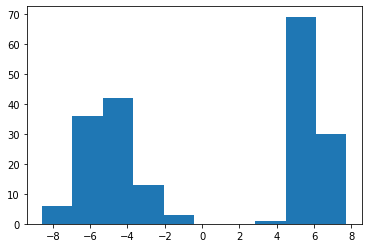

In [3]:
from scipy.stats import t, cauchy, skewnorm
data = np.concatenate([
        [t.rvs(5, loc=-5) for _ in range(100)],
        [skewnorm.rvs(2, loc=5) for _ in range(100)]])

plt.hist(data)

In [4]:
# np.savetxt("data/data_univ_1.txt", data)
data = np.loadtxt("data/data_univ_1.txt")

In [8]:
strauss_params = make_default_strauss(data.reshape(-1, 1))
gamma_prec_params = params_pb2.GammaParams(alpha=2, beta=2)
gamma_jump_params = params_pb2.GammaParams(alpha=1, beta=100)

strauss_params.init.gamma = 1e-30
strauss_params.init.beta = 1e-20
strauss_params.init.R = 5.0
strauss_params.fixed_params = True


sampler = ConditionalMCMC(pp_params=strauss_params, 
                          prec_params=gamma_prec_params,
                          jump_params=gamma_prec_params,
                          mala_stepsize=0.001)


sampler.run(10000, 10000, 1, data)

Burnin, iter # 200  /  10000
Burnin, iter # 400  /  10000
Burnin, iter # 600  /  10000
Burnin, iter # 800  /  10000
Burnin, iter # 1000  /  10000
Burnin, iter # 1200  /  10000
Burnin, iter # 1400  /  10000
Burnin, iter # 1600  /  10000
Burnin, iter # 1800  /  10000
Burnin, iter # 2000  /  10000
Burnin, iter # 2200  /  10000
Burnin, iter # 2400  /  10000
Burnin, iter # 2600  /  10000
Burnin, iter # 2800  /  10000
Burnin, iter # 3000  /  10000
Burnin, iter # 3200  /  10000
Burnin, iter # 3400  /  10000
Burnin, iter # 3600  /  10000
Burnin, iter # 3800  /  10000
Burnin, iter # 4000  /  10000
Burnin, iter # 4200  /  10000
Burnin, iter # 4400  /  10000
Burnin, iter # 4600  /  10000
Burnin, iter # 4800  /  10000
Burnin, iter # 5000  /  10000
Burnin, iter # 5200  /  10000
Burnin, iter # 5400  /  10000
Burnin, iter # 5600  /  10000
Burnin, iter # 5800  /  10000
Burnin, iter # 6000  /  10000
Burnin, iter # 6200  /  10000
Burnin, iter # 6400  /  10000
Burnin, iter # 6600  /  10000
Burnin, iter #

In [ ]:
# sampler.serialize_chains("data/data_1_chains.recordio")

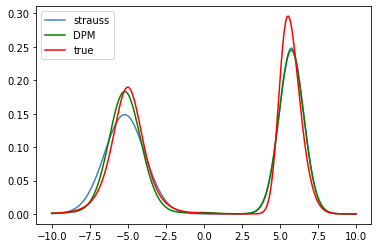

In [11]:
grid = np.linspace(-10, 10, 200)
dens = estimate_density_seq(sampler.chains, grid)

bnpmix_estimate = np.loadtxt("data/data_1_univ_dens_bnpmix.txt")

plt.plot(grid, np.mean(dens, axis=0), label="strauss", color="steelblue")
plt.plot(grid, np.mean(bnpmix_estimate, axis=0), label="DPM", color="green")
plt.plot(grid, 0.5*t.pdf(grid, 5, loc=-5) + 0.5*skewnorm.pdf(grid, 2, loc=5), label="true", color="red")
plt.legend()

plt.savefig("images/data_univ_1_dens_estimate.pdf")
plt.show()

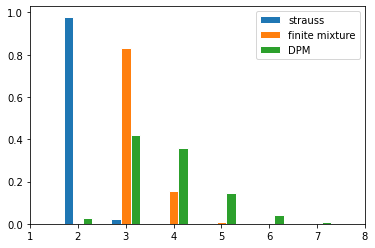

In [12]:
k_chain_raf = np.loadtxt("data/data_univ_1_K_raf.txt")
k_chain_bnp = np.loadtxt("data/data_1_univ_K_bnpmix.txt")


chains = sampler.chains
ma_chain = np.array([max(x.clus_alloc) + 1 for x in chains])
mna_chain = np.array([(x.mna) for x in chains])
# np.savetxt("data/data_1_K_our.txt", ma_chain)

width = 0.2
bars = np.arange(max(np.max(ma_chain), 4))
heights = np.array([np.sum(ma_chain ==i ) for i in bars])
plt.bar(bars - width, heights / len(ma_chain), width=width,
        edgecolor="white", label="strauss")

bars = np.arange(max(np.max(k_chain_raf), 4))
heights = np.array([np.sum(k_chain_raf ==i ) for i in bars])
plt.bar(bars, heights / len(k_chain_raf), width=width,
        edgecolor="white", label="finite mixture")

bars = np.arange(max(np.max(k_chain_bnp), 4))
heights = np.array([np.sum(k_chain_bnp ==i ) for i in bars])
plt.bar(bars + width, heights / len(k_chain_bnp), width=width,
        edgecolor="white", label="DPM")

plt.xlim((1, 8))

plt.legend()
plt.savefig("images/data_univ_1_histogram_K.pdf")
plt.show()

In [ ]:
sampler.chains[i-1].pp_state

In [ ]:
i = 305
print(sampler.chains[i].a_means)
print(sampler.chains[i].na_means)

In [ ]:
u_chain = np.array([x.u for x in sampler.chains])[200:]

In [ ]:
u_chain[i]

## FAITHFUL

In [ ]:
import pandas as pd
data = pd.read_csv("data/faithful.csv").values

In [ ]:
sampler = ConditionalMCMC(params_file="pp_mix/resources/sampler_params.asciipb")

sampler.run(25000, 25000, 5, data)

In [ ]:
sampler.chains[-1]

In [ ]:
az.plot_trace(extract_chain(chains[30000:], "ma"))

In [ ]:
from scipy.interpolate import griddata
x_ = np.linspace(1, 6, 100)
y_ = np.linspace(1, 6, 100)
x, y = np.meshgrid(x_, y_)
grid = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

chains = np.array(chains[30000:])
estimates = estimate_density_seq(chains, grid)

Z = griddata(grid, np.mean(estimates, axis=0), (x, y))
fig = plt.figure(figsize=(7, 7))
plt.contour(x, y, Z)
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [ ]:
chains[100]